In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ujson as json
import glob as g
import random as rnd
import os.path as op
import time
import math
import numpy as np
from skimage import io, transform
import skimage.color as skc

import pandas as pd
import seaborn

import multiprocessing
import hashlib as hl
import scipy.spatial.distance as sd

In [10]:
catalog = json.load(open('/media/jakob/bigdata/train/S.json', 'r'))
len(catalog['pages'])

18436

In [11]:
test_split = 0.7
# original_shape = 44,  66 , 3
tile_shape = 48,  48 , 3
SAMPLE_SIZE = 48
TILE_SIZE = 16
sample_shape = TILE_SIZE, TILE_SIZE, 3

In [12]:
def sample_img_data(catalog, k=None, rand=None, ext='.jpg'):
    if not k:
        k = len(catalog['pages'])
    if not rand:
        rand = rnd.Random(catalog['name'])
    path = catalog['path']
    sample = rand.sample(catalog['pages'],k)
    for page in sample:
        yield op.join(path, page['path'] + ext)

def preprocess(path, shape=(44, 66)):
    img = io.imread(path)
    return transform.resize(img,shape)



# pool = multiprocessing.Pool(processes=4)
# images = np.stack(pool.map(preprocess,sample_img_data(catalog,k=10000)))
# pool.close()
# pool.join()
# np.save('/media/jakob/bigdata/train/S_{}_{}'.format(*images.shape[1:-1]), images)

In [44]:

pool = multiprocessing.Pool(processes=4)
images = np.concatenate(pool.map(random_img_tiles,sample_img_data(catalog,k=320)))
pool.close()
pool.join()
np.save('/media/jakob/bigdata/train/S_Tiles_{}_{}'.format(*images.shape), images)

## Image sampling 

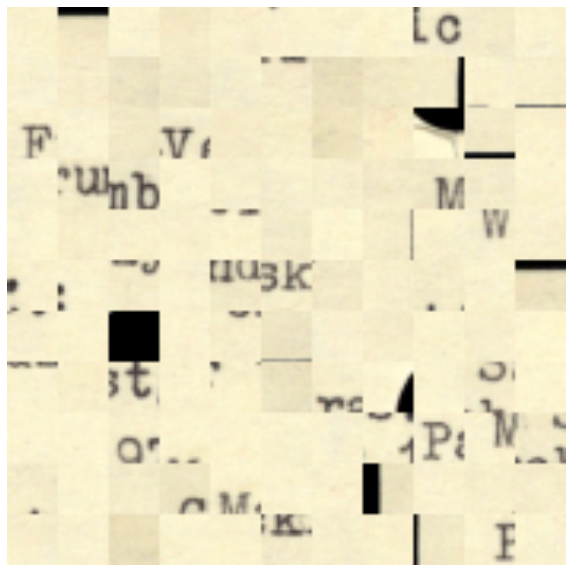

In [13]:
def img_grid(sample_selected, original_shape):
    n = int(math.floor(math.sqrt(len(sample_selected))))
    figure = np.zeros((original_shape[0] * n, original_shape[1] * n, 3),np.float32)
    for i in range(0,n):
        for j in range(0,n):
            digit = sample_selected[j * n + i].reshape(original_shape)
            figure[i * original_shape[0]: (i + 1) * original_shape[0],
                   j * original_shape[1]: (j + 1) * original_shape[1]] = digit
    return figure

def random_img_tiles(path, k=16, tile_size=TILE_SIZE, sample_size=SAMPLE_SIZE):
    tile_dim = tile_size * tile_size * 3
    img = skc.rgb2hsv(io.imread(path))
    rand_x = rnd.Random(path)
    rand_y = rnd.Random(''.join(reversed(path)))
    y_max , x_max, _ = img.shape
    tiles = np.zeros((k,tile_dim), dtype=np.float32)
    for i in range(k):        
        x_offset = rand_x.randint(0, x_max - sample_size)
        y_offset = rand_y.randint(0, y_max - sample_size)
        tile = img[y_offset:y_offset + sample_size,
                  x_offset:x_offset + sample_size]
        tile = transform.resize(tile,(tile_size, tile_size))
        tiles[i] = tile.reshape(tile_dim)
    
    return tiles

fig = plt.figure(figsize=(10, 10))

segments = random_img_tiles(list(sample_img_data(catalog,k=1))[0],k=128)
ax = plt.imshow(skc.hsv2rgb(img_grid(segments,  sample_shape)) )
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.savefig('../plots/random_tiles.pdf')

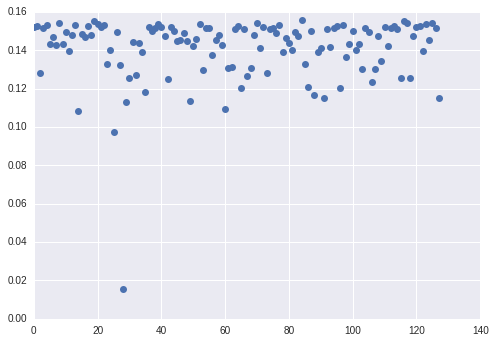

In [14]:
plt.plot(np.var(segments,1), 'o')

In [15]:
images = np.load('/media/jakob/bigdata/train/S_Tiles_5120_768.npy')
x_train = images[:int(len(images) * test_split)]
x_test  = images[int(len(images) * test_split):]
print(x_train.shape, x_train.dtype, len(x_test))
images = 0

((3584, 768), dtype('float32'), 1536)


In [16]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## VAE-Test
see https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [17]:

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

batch_size = 32
original_dim = x_train.shape[1]
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01
nb_epoch = 40

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

print original_dim

768


In [18]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss


In [19]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_std])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_std])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.n_epochs= 0 

In [25]:
loss = history.history['loss']

NameError: name 'history' is not defined

In [27]:
n_epochs = 100
history = vae.fit(x_train, x_train,
        verbose=0,
#         callbacks=[hera_model.callback],
        shuffle=False,
        nb_epoch=n_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
vae.n_epochs = vae.n_epochs + n_epochs
loss = np.concatenate([loss, history.history['loss']],0)

ValueError: Shape mismatch: x has 768 cols (and 32 rows) but y has 3072 rows (and 128 cols)
Apply node that caused the error: Dot22(input_1, dense_1_W)
Toposort index: 7
Inputs types: [TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(32, 768), (3072, 128)]
Inputs strides: [(3072, 4), (512, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Dot22.0, InplaceDimShuffle{x,0}.0), Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)](TensorConstant{(1, 1) of 0.5}, Elemwise{add,no_inplace}.0, Dot22.0, InplaceDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

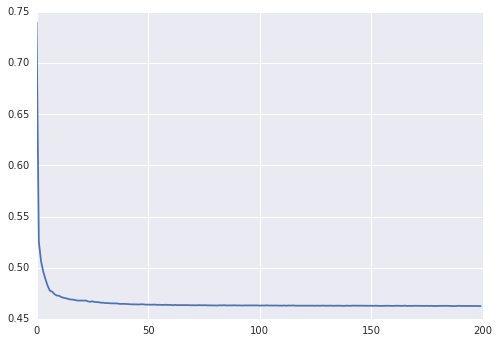

In [108]:
plt.plot(loss)

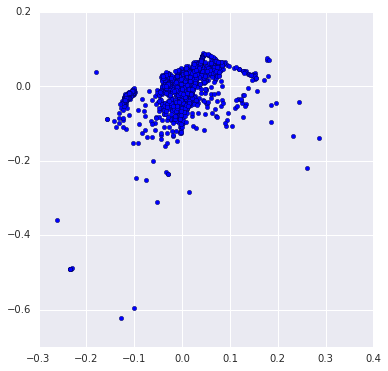

In [109]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
# plt.colorbar()
plt.show()

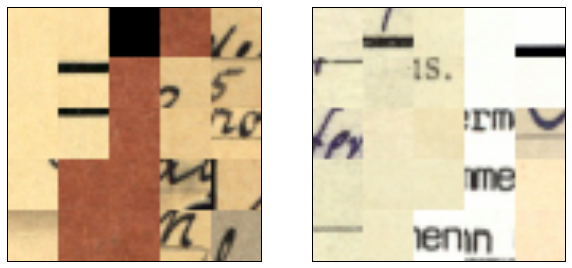

In [44]:
border = 0.07
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sample_selected = x_test[x_test_encoded[:,0] < border][::2]         
plt.imshow(skc.hsv2rgb(img_grid(sample_selected[:32], sample_shape)))
ax = plt.subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sample_selected = x_test[x_test_encoded[:,0] > border][::2]         
plt.imshow(skc.hsv2rgb(img_grid(sample_selected[:32], sample_shape)))

fig.savefig('../plots/vae_tile_groups.pdf')

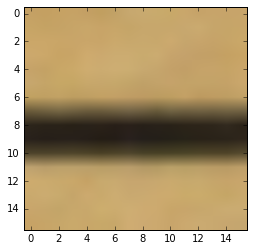

In [60]:
plt.imshow(skc.hsv2rgb(x_test[727].reshape(sample_shape)))

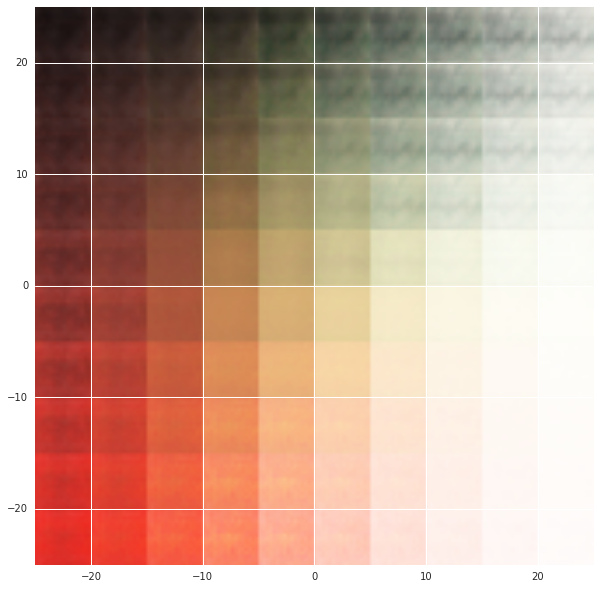

In [110]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 28 
figure = np.zeros((sample_shape[0] * n, sample_shape[1] * n, 3))
# we will sample n points within [-15, 15] standard deviations
space = 25
grid_x = np.linspace(-space, space, n)
grid_y = np.linspace(-space, space, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = skc.hsv2rgb(x_decoded[0].reshape(sample_shape))
        figure[i * sample_shape[0]: (i + 1) * sample_shape[0],
               j * sample_shape[1]: (j + 1) * sample_shape[1]] = digit

fig = plt.figure(figsize=(10, 10))
plt.imshow(figure,extent=[-space,space,-space, space])
fig.savefig('../plots/vae_{}.pdf'.format(vae.n_epochs))

In [74]:
img_paths = list(sample_img_data(catalog,k=20))
images = map(random_img_tiles,img_paths)

In [75]:
thumbs = list(map(preprocess, img_paths))

In [87]:
avg_pred = lambda tiles: sd.euclidean(np.mean(encoder.predict(tiles),0),card_cat_mean)
pred = np.stack(map(avg_pred, images),0)

In [88]:
pred

array([ 0.22103587,  0.3379726 ,  0.10219363,  0.10012434,  0.1030471 ,
        0.06604912,  0.18123818,  0.11158064,  0.08749171,  0.13135343,
        0.11964073,  0.10670184,  0.0869098 ,  0.00647994,  0.24606986,
        0.01155616,  0.1091045 ,  0.15509466,  0.14284063,  0.23555195])

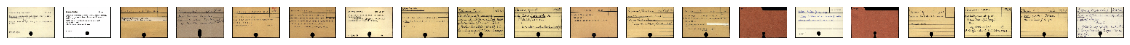

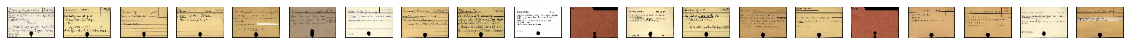

In [111]:
sort = [thumb for val, thumb in sorted(zip(pred, thumbs))]

def img_rows(rows):
    n = 0
    for i_r, row in enumerate(rows):
        plt.figure(figsize=(20, 2))
        for i in range(len(row)):
            n = n + 1
            ax = plt.subplot(i_r + 1, len(row), n)
            plt.imshow(row[i])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

img_rows([thumbs, sort])
# sort = [thumb for val, thumb in sorted(zip(pred[:,0], thumbs))]
# n = len(thumbs)
# plt.figure(figsize=(20, 2))
# for i in range(n):
#     ax = plt.subplot(2, n, n + i + 1)
#     plt.imshow(thumbs[i])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [21]:
vae_dir = '/media/jakob/bigdata/models/vae_card_samples/'
vae_name =  'vae1_card_samples'

In [96]:
def save_model(model, model_dir, name):
    with open(op.join(model_dir, name + '.json'), 'w') as model_json_file:
        model_json_file.write(model.to_json())
    vae.save_weights(op.join(model_dir, name + '.h5'))

save_model(vae, vae_dir , vae_name + '_{}'.format(vae.n_epochs))


In [22]:
vae.load_weights(op.join(vae_dir,vae_name + '.h5'))

In [70]:
card_cat = pd.read_csv('/media/jakob/bigdata/card_catogeries/seperators.csv',header=None, names=['name', 'class'])
card_cat_paths = map(lambda name: op.join(catalog['path'],name), card_cat['name'] + '.jpg')
card_cat_paths

[u'/media/jakob/bigdata/train/S/S002/00000238.jpg',
 u'/media/jakob/bigdata/train/S/S002/00000731.jpg',
 u'/media/jakob/bigdata/train/S/S091/00000001.jpg',
 u'/media/jakob/bigdata/train/S/S143/00000001.jpg']

In [71]:
images = map(random_img_tiles,card_cat_paths)
card_cat_pred = np.array([np.mean(encoder.predict(sample),0) for sample in images])

In [79]:
card_cat_mean = np.array(card_cat_pred).mean(0)

In [23]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.scatter(card_cat_pred[:, 0], card_cat_pred[:, 1], color='r')
# plt.colorbar()
plt.show()

ValueError: Shape mismatch: x has 768 cols (and 32 rows) but y has 3072 rows (and 128 cols)
Apply node that caused the error: Dot22(input_1, dense_1_W)
Toposort index: 2
Inputs types: [TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(32, 768), (3072, 128)]
Inputs strides: [(3072, 4), (512, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{(i0 * (Abs((i1 + i2)) + i1 + i2))}}[(0, 1)](TensorConstant{(1, 1) of 0.5}, Dot22.0, InplaceDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [101]:
x_test_encoded
code_dist = lambda tiles: sd.euclidean(tiles,card_cat_mean)
pred = np.stack(map(code_dist, x_test_encoded),0)

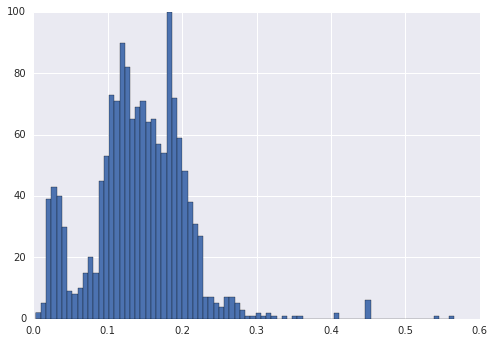

In [115]:
plt.hist(pred,bins=80)
plt.show()

In [6]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.line(x, y, legend="Temp.", line_width=2)

# show the results
show(p)

Loading BokehJS ...